# Step0: Import Packages

In [13]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
from sklearn import metrics
from torchviz import make_dot
from string import punctuation
import torch.nn.functional as F
from collections import Counter
from torchvision.models import AlexNet
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, TensorDataset

# Step1: Get dataset

In [2]:
reviews = pd.read_csv("../data/english_yep_reviews.csv")

# Step2: Count the words

In [3]:
all_reviews = list(reviews['cleaned'])
all_text = " ".join(all_reviews)
all_words = all_text.split()
print(all_words[0:10])

# Count all the words using Counter Method
count_words = Counter(all_words)
total_words = len(all_words)
sorted_words=count_words.most_common(total_words)
print("Top ten occuring words : ", sorted_words[:10])

['someon', 'ha', 'work', 'mani', 'museum', 'wa', 'eager', 'visit', 'thi', 'galleri']
Top ten occuring words :  [('wa', 199857), ('thi', 86639), ('place', 55772), ('food', 53489), ('good', 50852), ('great', 44401), ('veri', 44062), ('time', 42695), ('get', 38251), ('would', 38160)]


# Step3: Create a dictionary

In [4]:
# Create a dictionary
# We will start createing dictionary with index 1 because 0 
    # is reserved for padding

vocab_to_int = {w: i+1 for i, (w, c) in enumerate(sorted_words)}

# Step4: Encode the review data

In [5]:
# Encode review
encoded_reviews = list()
for review in all_reviews:
    encoded_review = list()
    for word in review.split():
        if word not in vocab_to_int.keys():
            # if word is not available in vocab_to_int put 0 in that place
            encoded_review.append(0)
        else:
            encoded_review.append(vocab_to_int[word])
    encoded_reviews.append(encoded_review)

# Step5: Make the encode_review of the same length

In [6]:
# make all the encoded_review of the same length
# this step will return features of review_ints,
# where each review is padded with 0's or truncated to the input seq_length.
# the longest review has 564 words
# sequence_length is 100, but also could be 150, 200, 250 (here just for save energy)

sequence_length = 100
features = np.zeros((len(encoded_reviews), sequence_length), dtype=int)
for i, review in enumerate(encoded_reviews):
    review_len = len(review)
    if review_len <= sequence_length:
        zeros = list(np.zeros(sequence_length-review_len))
        new = zeros+review
    else:
        new = review[:sequence_length]
    features[i, :] = np.array(new)

# Step6: Create labels

In [7]:
# set labels, 0 negative, 1 neutral, 2 positive
labels = list(reviews['Review_Labels'])

# Step7: Split this feature data into Traning, Testing and Validation set

In [8]:
# split this feature data into training and validation set
# 80% training, 10% test and 10% validation dataset

# However, for cpu running, set 10% of them
# features = features[:int(0.5*len(features))]
# labels = labels[:int(0.5*len(labels))]
train_x = features[:int(0.8*len(features))]
train_y = labels[:int(0.8*len(features))]
valid_x = features[int(0.8*len(features)):int(0.9*len(features))]
valid_y = labels[int(0.8*len(features)):int(0.9*len(features))]
test_x = features[int(0.9*len(features)):]
test_y = labels[int(0.9*len(features)):]
print(len(train_y), len(valid_y), len(test_y))

79999 10000 10000


# Step8: Create DataLoader objects for Pytorch model

In [9]:
import torch
from torch.utils.data import DataLoader, TensorDataset

#create Tensor Dataset
train_data=TensorDataset(torch.FloatTensor(train_x), torch.FloatTensor(train_y))
valid_data=TensorDataset(torch.FloatTensor(valid_x), torch.FloatTensor(valid_y))
test_data=TensorDataset(torch.FloatTensor(test_x), torch.FloatTensor(test_y))

#dataloader
# remember to add drop_last=True, which will delete the last batch of the data if it's size is not equal to batch_size
batch_size=400
train_loader=DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
valid_loader=DataLoader(valid_data, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader=DataLoader(test_data, batch_size=batch_size, shuffle=True, drop_last=True)

# Step9: Analyze the dataloader data

In [10]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()
print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample label size: ', sample_y.size()) # batch_size
print('Sample label: \n', sample_y)

Sample input size:  torch.Size([400, 100])
Sample input: 
 tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 2.3350e+03, 5.4300e+02,
         1.3600e+03],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 6.0000e+00, 4.0000e+00,
         1.2000e+01],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 3.9000e+01, 1.5000e+02,
         4.2000e+01],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 8.8000e+01, 5.0000e+01,
         1.4800e+02],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 6.8000e+01, 6.0000e+00,
         1.2000e+01],
        [1.1630e+03, 1.6300e+03, 3.6200e+02,  ..., 9.0000e+00, 7.3890e+03,
         1.7390e+03]])
Sample label size:  torch.Size([400])
Sample label: 
 tensor([0., 2., 2., 2., 2., 2., 2., 2., 0., 2., 2., 0., 2., 0., 2., 0., 0., 2.,
        2., 2., 1., 2., 2., 2., 2., 2., 0., 2., 2., 2., 2., 1., 2., 1., 1., 0.,
        2., 2., 2., 2., 2., 2., 0., 2., 2., 2., 1., 0., 2., 2., 0., 2., 2., 2.,
        2., 1., 2., 2., 2., 2., 0., 2., 2., 0., 2.,

# Step10: Create an CNN model

In [11]:
class CNN_Model(nn.Module):
    def __init__(self, vocab_size, embed, num_filters, filter_size, num_classes, dropout):
        super(CNN_Model, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embed, padding_idx=vocab_size - 1)
        self.convs = nn.ModuleList(
                    [nn.Conv2d(1, num_filters, (k, embed)) for k in filter_sizes])
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(num_filters * len(filter_sizes), num_classes)
        
    def conv_and_pool(self, x, conv):
        x = F.relu(conv(x)).squeeze(3)
        x = F.max_pool1d(x, x.size(2)).squeeze(2)
        
        return x
    
    def forward(self, x):
#         print(x.shape)
        out = self.embedding(x[0])
#         print(out.shape)
        out = out.unsqueeze(1)
#         print(out.shape)
        out = torch.cat([self.conv_and_pool(out, conv) for conv in self.convs], 1)
#         print(out.shape)
        out = self.dropout(out)
#         print(out.shape)
        out = self.fc(out)
#         print(out.shape)
        
        return out

# Step11: Initialize the CNN models

In [18]:
vocab_size = len(vocab_to_int) + 1
embed = 300
filter_sizes = (2, 3, 4, 5)
num_filters = 256
num_classes = 3
dropout = 0.5

model_cnn = CNN_Model(vocab_size, embed, num_filters, filter_sizes, num_classes, dropout)
print(model_cnn)

CNN_Model(
  (embedding): Embedding(77398, 300, padding_idx=77397)
  (convs): ModuleList(
    (0): Conv2d(1, 256, kernel_size=(2, 300), stride=(1, 1))
    (1): Conv2d(1, 256, kernel_size=(3, 300), stride=(1, 1))
    (2): Conv2d(1, 256, kernel_size=(4, 300), stride=(1, 1))
    (3): Conv2d(1, 256, kernel_size=(5, 300), stride=(1, 1))
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=1024, out_features=3, bias=True)
)


# Step12: Train the model

In [21]:
def train_cnn(epoch, model):
    lr = 0.001  # learning rate
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.001)
    total_batch = 0
    train_loss = 0
    result_train_dict = {}
    result_valid_dict = {}
    epoch_train_list = []
    epoch_valid_list = []
    batch_train_list = []
    batch_valid_list = []
    loss_train_list = []
    loss_valid_list = []
    acc_train_list = []
    acc_valid_list = []
    f1_train_list = []
    f1_valid_list = []
    recall_train_list = []
    recall_valid_list = []
    
    for batch_idx, (trains, labels) in enumerate(train_loader):
        
        outputs = model(trains.long()[None, ...])
        model.zero_grad()
        loss = F.cross_entropy(outputs, labels.long())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
        
        true = labels.data.cpu()
        predic = torch.max(outputs.data, 1)[1].cpu()
        train_acc = metrics.accuracy_score(true, predic)
        train_f1 = metrics.f1_score(true, predic, average='micro')
        train_recall = metrics.recall_score(true, predic, average='micro')
        train_loss_value = train_loss/(batch_idx+1)
        
        epoch_train_list.append(epoch)
        batch_train_list.append(batch_idx)
        loss_train_list.append(train_loss_value)
        acc_train_list.append(train_acc)
        f1_train_list.append(train_f1)
        recall_train_list.append(train_recall)
        
        if total_batch % 20 == 0 :
            
            for trains, labels in valid_loader:
                outputs = model(trains.long()[None, ...])
                valid_loss = F.cross_entropy(outputs, labels.long())
                true = labels.data.cpu()
                predic = torch.max(outputs.data, 1)[1].cpu()
                valid_acc = metrics.accuracy_score(true, predic)
                valid_f1 = metrics.f1_score(true, predic, average='micro')
                valid_recall = metrics.recall_score(true, predic, average='micro')
                
                epoch_valid_list.append(epoch)
                batch_valid_list.append(batch_idx)
                loss_valid_list.append(valid_loss.item())
                acc_valid_list.append(valid_acc)
                f1_valid_list.append(valid_f1)
                recall_valid_list.append(valid_recall)
                
                avg_acc_valid = np.array(acc_valid_list).mean()
                avg_loss_valid = np.array(loss_valid_list).mean()
                
            print('epoch: {}'.format(epoch), 'batch: {}'.format(batch_idx), 
                  'total train loader: {}'.format(len(train_loader)),
                  'T_Loss: %.3f | T_Acc: %.3f |' % (train_loss_value, train_acc),
                  'T_f1: %.3f | T_recall: %.3f ||' % (train_f1, train_recall),
                  'V_Loss: %.3f | V_Acc: %.3f' % (avg_loss_valid, avg_acc_valid),
                  'V_f1: %.3f | V_recall: %.3f' % (valid_f1, valid_recall))
            
        total_batch += 1
        
    result_train_dict['epoch'] = epoch_train_list
    result_train_dict['batch'] = batch_train_list
    result_train_dict['loss'] = loss_train_list
    result_train_dict['acc'] = acc_train_list
    result_train_dict['f1'] = f1_train_list
    result_train_dict['recall'] = recall_train_list
    
    result_valid_dict['epoch'] = epoch_valid_list
    result_valid_dict['batch'] = batch_valid_list
    result_valid_dict['loss'] = loss_valid_list
    result_valid_dict['acc'] = acc_valid_list
    result_valid_dict['f1'] = f1_valid_list
    result_valid_dict['recall'] = recall_valid_list

    pd_train = pd.DataFrame(result_train_dict)
    pd_valid = pd.DataFrame(result_valid_dict)
    
    return pd_train, pd_valid

## Step12-1. CNN model

In [22]:
epochs = 15
cnn_train_result = pd.DataFrame()
cnn_valid_result = pd.DataFrame()
for epoch in range(epochs):
    train_result, valid_result = train_cnn(epoch, model_cnn)
    cnn_train_result = cnn_train_result.append(train_result, ignore_index=True)
    cnn_valid_result = cnn_valid_result.append(train_result, ignore_index=True)

epoch: 0 batch: 0 total train loader: 199 T_Loss: 1.283 | T_Acc: 0.680 | T_f1: 0.680 | T_recall: 0.680 || V_Loss: 1.199 | V_Acc: 0.391 V_f1: 0.395 | V_recall: 0.395
epoch: 0 batch: 20 total train loader: 199 T_Loss: 0.844 | T_Acc: 0.703 | T_f1: 0.703 | T_recall: 0.703 || V_Loss: 0.935 | V_Acc: 0.562 V_f1: 0.725 | V_recall: 0.725
epoch: 0 batch: 40 total train loader: 199 T_Loss: 0.754 | T_Acc: 0.730 | T_f1: 0.730 | T_recall: 0.730 || V_Loss: 0.825 | V_Acc: 0.630 V_f1: 0.785 | V_recall: 0.785
epoch: 0 batch: 60 total train loader: 199 T_Loss: 0.704 | T_Acc: 0.792 | T_f1: 0.792 | T_recall: 0.792 || V_Loss: 0.763 | V_Acc: 0.665 V_f1: 0.767 | V_recall: 0.767
epoch: 0 batch: 80 total train loader: 199 T_Loss: 0.671 | T_Acc: 0.745 | T_f1: 0.745 | T_recall: 0.745 || V_Loss: 0.719 | V_Acc: 0.689 V_f1: 0.802 | V_recall: 0.802
epoch: 0 batch: 100 total train loader: 199 T_Loss: 0.648 | T_Acc: 0.800 | T_f1: 0.800 | T_recall: 0.800 || V_Loss: 0.688 | V_Acc: 0.707 V_f1: 0.792 | V_recall: 0.792
epoc

epoch: 5 batch: 0 total train loader: 199 T_Loss: 0.364 | T_Acc: 0.875 | T_f1: 0.875 | T_recall: 0.875 || V_Loss: 0.468 | V_Acc: 0.823 V_f1: 0.820 | V_recall: 0.820
epoch: 5 batch: 20 total train loader: 199 T_Loss: 0.370 | T_Acc: 0.848 | T_f1: 0.848 | T_recall: 0.848 || V_Loss: 0.460 | V_Acc: 0.826 V_f1: 0.818 | V_recall: 0.818
epoch: 5 batch: 40 total train loader: 199 T_Loss: 0.386 | T_Acc: 0.823 | T_f1: 0.823 | T_recall: 0.823 || V_Loss: 0.457 | V_Acc: 0.825 V_f1: 0.828 | V_recall: 0.828
epoch: 5 batch: 60 total train loader: 199 T_Loss: 0.391 | T_Acc: 0.815 | T_f1: 0.815 | T_recall: 0.815 || V_Loss: 0.457 | V_Acc: 0.825 V_f1: 0.830 | V_recall: 0.830
epoch: 5 batch: 80 total train loader: 199 T_Loss: 0.390 | T_Acc: 0.863 | T_f1: 0.863 | T_recall: 0.863 || V_Loss: 0.455 | V_Acc: 0.826 V_f1: 0.840 | V_recall: 0.840
epoch: 5 batch: 100 total train loader: 199 T_Loss: 0.393 | T_Acc: 0.828 | T_f1: 0.828 | T_recall: 0.828 || V_Loss: 0.454 | V_Acc: 0.825 V_f1: 0.785 | V_recall: 0.785
epoc

epoch: 10 batch: 0 total train loader: 199 T_Loss: 0.291 | T_Acc: 0.880 | T_f1: 0.880 | T_recall: 0.880 || V_Loss: 0.413 | V_Acc: 0.838 V_f1: 0.853 | V_recall: 0.853
epoch: 10 batch: 20 total train loader: 199 T_Loss: 0.343 | T_Acc: 0.895 | T_f1: 0.895 | T_recall: 0.895 || V_Loss: 0.416 | V_Acc: 0.837 V_f1: 0.843 | V_recall: 0.843
epoch: 10 batch: 40 total train loader: 199 T_Loss: 0.352 | T_Acc: 0.815 | T_f1: 0.815 | T_recall: 0.815 || V_Loss: 0.415 | V_Acc: 0.838 V_f1: 0.838 | V_recall: 0.838
epoch: 10 batch: 60 total train loader: 199 T_Loss: 0.355 | T_Acc: 0.853 | T_f1: 0.853 | T_recall: 0.853 || V_Loss: 0.415 | V_Acc: 0.838 V_f1: 0.833 | V_recall: 0.833
epoch: 10 batch: 80 total train loader: 199 T_Loss: 0.357 | T_Acc: 0.853 | T_f1: 0.853 | T_recall: 0.853 || V_Loss: 0.414 | V_Acc: 0.838 V_f1: 0.858 | V_recall: 0.858
epoch: 10 batch: 100 total train loader: 199 T_Loss: 0.361 | T_Acc: 0.890 | T_f1: 0.890 | T_recall: 0.890 || V_Loss: 0.414 | V_Acc: 0.839 V_f1: 0.840 | V_recall: 0.84

epoch: 14 batch: 180 total train loader: 199 T_Loss: 0.382 | T_Acc: 0.825 | T_f1: 0.825 | T_recall: 0.825 || V_Loss: 0.404 | V_Acc: 0.843 V_f1: 0.818 | V_recall: 0.818


In [34]:
cnn_train_result['roll_180_acc'] = cnn_train_result['acc'].rolling(180).mean()
cnn_valid_result['roll_180_acc'] = cnn_valid_result['acc'].rolling(180).mean()
cnn_train_result['roll_180_loss'] = cnn_train_result['loss'].rolling(180).mean()
cnn_valid_result['roll_180_loss'] = cnn_valid_result['loss'].rolling(180).mean()

In [35]:
cnn_train_result.to_csv('../result/CNN/cnn_train_result.csv')
cnn_valid_result.to_csv('../result/CNN/cnn_valid_result.csv')

In [36]:
cnn_valid_result.head()

,epoch,batch,loss,acc,f1,recall,roll_730_acc,roll_730_loss,roll_180_acc,roll_180_loss
0,0,0,1.283019,0.6800,0.6800,0.6800,NaN,NaN,NaN,NaN
1,0,1,1.249004,0.4100,0.4100,0.4100,NaN,NaN,NaN,NaN
2,0,2,1.168219,0.5225,0.5225,0.5225,NaN,NaN,NaN,NaN
3,0,3,1.139716,0.5975,0.5975,0.5975,NaN,NaN,NaN,NaN
4,0,4,1.082650,0.7175,0.7175,0.7175,NaN,NaN,NaN,NaN


In [47]:
cnn_train_result.iloc[-1]

epoch             14.000000
batch            198.000000
loss               0.383695
acc                0.827500
f1                 0.827500
recall             0.827500
roll_730_acc       0.851836
roll_730_loss      0.369081
roll_180_acc       0.848431
roll_180_loss      0.376631
Name: 2984, dtype: float64

# Step13: Test the model

In [37]:
def test(epoch, model):
    lr = 0.001  # learning rate
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    total_batch = 0
    result_dict = {}
    epoch_list = []
    batch_list = []
    loss_list = []
    acc_list = []
    recall_list = []
    f1_list = []
    
    for batch_idx, (trains, labels) in enumerate(test_loader):

        outputs = model(trains.long()[None, ...])
        
        true = labels.data.cpu()
        predic = torch.max(outputs.data, 1)[1].cpu()
        test_acc = metrics.accuracy_score(true, predic)
        test_loss = F.cross_entropy(outputs, labels.long())
        test_f1 = metrics.f1_score(true, predic, average='micro')
        test_recall = metrics.recall_score(true, predic, average='micro')
        
        epoch_list.append(epoch)
        batch_list.append(batch_idx)
        loss_list.append(test_loss.item())
        acc_list.append(test_acc)
        recall_list.append(test_recall)
        f1_list.append(test_f1)
            
        if total_batch % 50 == 0 :
            print('epoch: {}'.format(epoch), 'batch: {}'.format(batch_idx), 
                  'total train loader: {}'.format(len(test_loader)),
                  'Loss: %.3f | Acc: %.3f |' % (test_loss, test_acc),
                  'F1: %.3f | Recall: %.3f ' % (test_f1, test_recall))
        
#         total_batch += 1
        
    result_dict['epoch'] = epoch_list
    result_dict['batch'] = batch_list
    result_dict['loss'] = loss_list
    result_dict['acc'] = acc_list
    result_dict['f1'] = f1_list
    result_dict['recall'] = recall_list
    
    return pd.DataFrame(result_dict)

In [38]:
cnn_test_result = pd.DataFrame()
cnn_test_result = cnn_test_result.append(test(0, model_cnn), ignore_index=True)


epoch: 0 batch: 0 total train loader: 25 Loss: 0.350 | Acc: 0.850 | F1: 0.850 | Recall: 0.850 
epoch: 0 batch: 1 total train loader: 25 Loss: 0.452 | Acc: 0.825 | F1: 0.825 | Recall: 0.825 
epoch: 0 batch: 2 total train loader: 25 Loss: 0.409 | Acc: 0.845 | F1: 0.845 | Recall: 0.845 
epoch: 0 batch: 3 total train loader: 25 Loss: 0.391 | Acc: 0.845 | F1: 0.845 | Recall: 0.845 
epoch: 0 batch: 4 total train loader: 25 Loss: 0.449 | Acc: 0.825 | F1: 0.825 | Recall: 0.825 
epoch: 0 batch: 5 total train loader: 25 Loss: 0.441 | Acc: 0.833 | F1: 0.833 | Recall: 0.833 
epoch: 0 batch: 6 total train loader: 25 Loss: 0.399 | Acc: 0.850 | F1: 0.850 | Recall: 0.850 
epoch: 0 batch: 7 total train loader: 25 Loss: 0.487 | Acc: 0.812 | F1: 0.812 | Recall: 0.812 
epoch: 0 batch: 8 total train loader: 25 Loss: 0.418 | Acc: 0.833 | F1: 0.833 | Recall: 0.833 
epoch: 0 batch: 9 total train loader: 25 Loss: 0.429 | Acc: 0.830 | F1: 0.830 | Recall: 0.830 
epoch: 0 batch: 10 total train loader: 25 Loss: 0.

In [39]:
cnn_test_result.to_csv('../result/CNN/cnn_test_result.csv')

In [40]:
cnn_test_result['acc'].mean()

0.8395

In [45]:
cnn_test_result['f1'].mean()

0.8395

In [46]:
cnn_test_result['recall'].mean()

0.8395

In [42]:
a = [1,2,3]

In [43]:
np.array(a).mean()

2.0

# Step14: plot the result

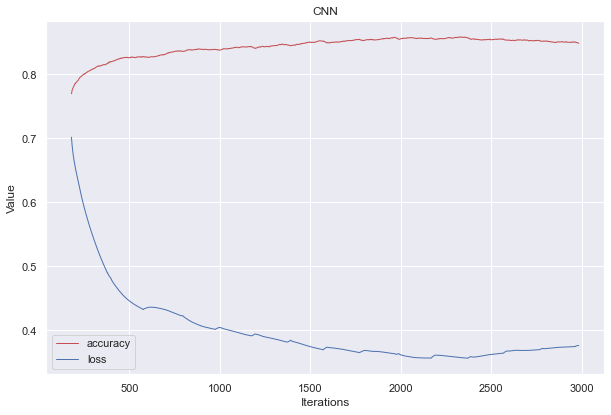

In [49]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set()

y1 = np.array(cnn_train_result['roll_180_acc'])
y2 = np.array(cnn_train_result['roll_180_loss'])

x = np.arange(len(y1))

plt.figure(figsize=(10, 6.5))

plt.plot(x, y1, color="r", linewidth=1, label='accuracy')
plt.plot(x, y2, color="b", linewidth=1, label='loss')

plt.legend(loc='best')
plt.xlabel('Iterations')
plt.ylabel('Value')
plt.title('CNN')

plt.show()